In this notebook, we'll build a simple [CTC](https://www.cs.toronto.edu/~graves/icml_2006.pdf) based handwriting recognition model using [GTN](https://github.com/facebookresearch/gtn) using the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database).



## Step 1: Setting up the environment


First, we will install gtn and import all the required modules. 

In [18]:
!pip install gtn
import gtn 
import os 
import numpy
import shutil
import json 
import random 
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display
import PIL 
import numpy as np 

Download [gtn_applications](https://github.com/facebookresearch/gtn_applications) github repo which contains scripts to download the dataset and train/evaluate models using PyTorch. 

In [2]:
shutil.rmtree("gtn_applications", ignore_errors=True)
!git clone https://github.com/facebookresearch/gtn_applications.git
assert os.path.exists("gtn_applications") and os.path.isdir("gtn_applications")
os.chdir("gtn_applications")

Cloning into 'gtn_applications'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (932/932), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 932 (delta 620), reused 912 (delta 607), pack-reused 0
Receiving objects: 100% (932/932), 200.23 KiB | 18.20 MiB/s, done.
Resolving deltas: 100% (620/620), done.


## Step 2: Downloading the dataset

Before you start the download, register here - https://fki.tic.heia-fr.ch/login and update the email and password fields in the next section  appropriately. This will take about 5 minutes.

In [3]:
if not os.path.exists("data"):
  os.mkdir("data")
  ! datasets/download/iamdb.sh data <replace_with_email> <replace_with_password>
else:
  print("Looks like dataset dir `data` exists alreeady. Delete the dir to download again !")

\nLogging in and creating a session ...
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>Redirecting...</title>
<h1>Redirecting...</h1>
<p>You should be redirected automatically to target URL: <a href="/">/</a>.  If not click the link.\nDownloading metadata ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2553k  100 2553k    0     0  1911k      0  0:00:01  0:00:01 --:--:-- 1909k
\nDownloading task definition ...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23009  100 23009    0     0  44333      0 --:--:-- --:--:-- --:--:-- 44333
Archive:  data/largeWriterIndependentTextLineRecognitionTask.zip
  inflating: data/LargeWriterIndependentTextLineRecognitionTask.txt  
  inflating: data/testset.txt        
  inflating: data/trainset.txt       
  inf

IAM Handwriting Database consists of handwritten English text. Let's take a look at few examples from trainset.

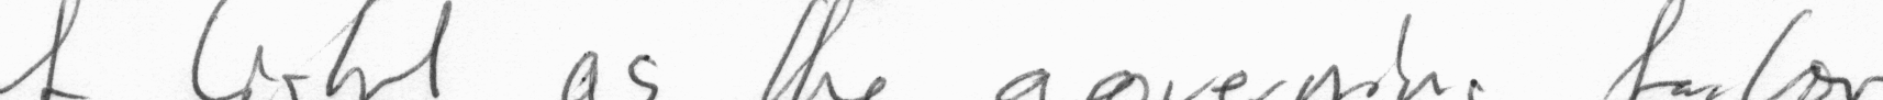

['lead-210|was|added|to|1-litre|aliquots'] 



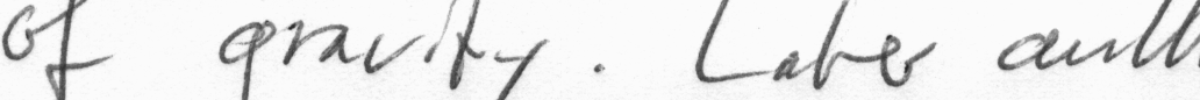

['I|wish|I|went|to|that|school|.'] 



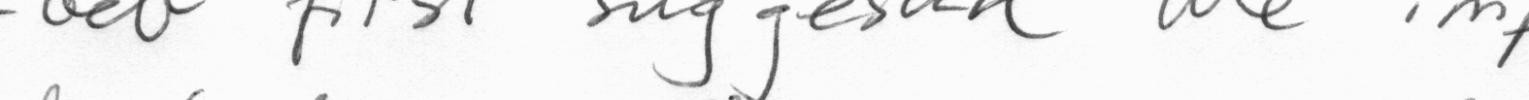

['He|was|able|to|pick|out|towns|,|unrecognisable|to|the'] 



In [35]:
num_examples = 3

def resize_image(src_img, size=(64,64), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new centered background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

with open("data/sentences.txt") as f:
  lines = f.readlines()
while num_examples:
  sample = random.choice(lines)
  cols = sample.split()
  if cols[2] == "err":
    continue 
  img_file = "-".join(cols[0].split("-", 2)[:2])
  img = PIL.Image.open(f"data/{name}.png")
  box = tuple(int(val) for val in cols[5 : 9])
  x, y, w, h = box
  height = 100
  size = (height, int((height / h) * w))
  cropped_img = transforms.functional.resized_crop(img, y, x, h, w, size)
  display(cropped_img)
  print(cols[9:] , "\n")

  num_examples -= 1
  

## Step 3: Training the model


In [31]:
# creating a checkpoint dir 
if not os.path.exists("checkpoint"):
  os.mkdir("checkpoint")

Creating a traininig config. For the neural network part, we will use `TDS2D` which is a 2D variant of [Time-Depth Separable (TDS)](https://arxiv.org/abs/1904.02619) convolution block.

In [32]:
config = {
  "seed" : 0,
  "data" : {
    "dataset" : "iamdb",
    "data_path" : "data/",
    "num_features" : 64
  },
  "model_type" : "tds2d",
  "model" : {
    "depth" : 4,
    "tds_groups" : [
      { "channels" : 4, "num_blocks" : 3, "stride" : [2, 2] },
      { "channels" : 16, "num_blocks" : 3, "stride" : [2, 2] },
      { "channels" : 32, "num_blocks" : 3, "stride" : [2, 1] },
      { "channels" : 64, "num_blocks" : 3, "stride" : [2, 1] }
    ],
    "kernel_size" : [5, 7],
    "dropout" : 0.1
  },
  "optim" : {
    "batch_size" : 32,
    "epochs" : 20, # Use 400 for better accuracy
    "learning_rate" : 1e-1,
    "step_size" : 100,
    "max_grad_norm" : 5
  }
}

with open("checkpoint/config.json", "w") as f:
  f.write(json.dumps(config))


Start training

In [33]:
%run -i train.py --config checkpoint/config.json --checkpoint_path checkpoint 

INFO:root:World size is : 1
INFO:root:Restoring model from epoch 0
INFO:root:Using the config 
{"seed": 0, "data": {"dataset": "iamdb", "data_path": "data/", "num_features": 64}, "model_type": "tds2d", "model": {"depth": 4, "tds_groups": [{"channels": 4, "num_blocks": 3, "stride": [2, 2]}, {"channels": 16, "num_blocks": 3, "stride": [2, 2]}, {"channels": 32, "num_blocks": 3, "stride": [2, 1]}, {"channels": 64, "num_blocks": 3, "stride": [2, 1]}], "kernel_size": [5, 7], "dropout": 0.1}, "optim": {"batch_size": 32, "epochs": 20, "learning_rate": 0.1, "step_size": 100, "max_grad_norm": 5}}
INFO:root:Loading dataset ...
INFO:root:Loading model ...
INFO:root:Training tds2d model with 2,644,859 parameters.
INFO:root:Starting training ...
INFO:root:Epoch 1 started. 
INFO:root:Epoch 1 complete. nUpdates 193, Loss 4.701, CER 95.241, WER 101.949, Time 288.997 (s), LR 0.100
INFO:root:Evaluating validation set..
INFO:root:Validation Set: Loss 3.790, CER 83.845, WER 98.860, Best Loss 3.790, Best CE

## Step 4: Evaluation

Evaluating on test set 


In [34]:
%run -i test.py --config checkpoint/config.json --checkpoint_path checkpoint --split test

Streaming output truncated to the last 5000 lines.
WER: 62.500
HYP: Aienrd▁of▁hers▁haing▁masried▁lesder▁Peron
REF friend▁of▁hers▁having▁married▁Lester▁Peron▁,
CER: 2.439
WER: 12.500
HYP: this▁can▁either▁mean▁that▁both▁sugyas▁are
REF This▁can▁either▁mean▁that▁both▁sugyas▁are
CER: 8.000
WER: 33.333
HYP: pice▁covers▁with▁a▁fringing▁of▁chumay▁boblles▁and
REF piece▁covers▁with▁a▁fringing▁of▁clumsy▁bobbles▁and
CER: 19.565
WER: 44.444
HYP: onalls▁poparatory▁to▁a▁last▁imbrace▁.▁"▁Ves
REF overalls▁preparatory▁to▁a▁last▁embrace▁.▁"▁You
CER: 8.696
WER: 36.364
HYP: an▁officershauld▁join▁a▁ship▁,▁en▁taking▁upo▁a
REF an▁officer▁should▁join▁a▁ship▁,▁on▁taking▁up▁a
CER: 22.222
WER: 87.500
HYP: boehave▁lihe▁angthingy▁ofthe▁lind▁.
REF behave▁like▁anything▁of▁the▁kind▁.▁I
CER: 13.953
WER: 33.333
HYP: ansng▁our▁own▁people▁,▁finding▁out▁jut▁lar
REF among▁our▁own▁people▁,▁finding▁out▁just▁how
CER: 2.632
WER: 11.111
HYP: say▁a▁word▁about▁it▁,▁lester▁wants▁his
REF say▁a▁word▁about▁it▁,▁Lester▁wants▁his
CER: 1

The trained model achieves a CER of 17.4 !

To get better results, train the model for more epochs. Also, using multi GPU training (`--world_size <ngpus>`) would make the training faster. 